# Detection of RNA-seqFISH spots

Here, we determine the spots for RNA-seqFISH. 

In [1]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
import pandas as pd

# Get the path of the current directory.
current_directory = os.getcwd()
# Get the path two levels up from the current directory.
dir = os.path.dirname(current_directory)


def spot_detect_threshold(Pos_no, file_name, threshold):                
    path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

    path = os.path.join(path_input, Pos_no, file_name)
    # Select the FISH image.
    dna  = stack.read_image(path)

    # Generate MIP (Maximum Intensity Projection) images for image display
    dna_mip = stack.maximum_projection(dna)

    # Nucleus image
    path = os.path.join(dir, "1_processed_images", "3_diveded_files", 
                        Pos_no, "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)


    # Spot detection
    # Perform filtering, detection of local maxima, detection of the optimal threshold, and detection of bright spots based on the threshold all at once.

    spots = detection.detect_spots(
        images=dna, 
        threshold = threshold,
        return_threshold=False, 
        voxel_size=(130, 130, 130),  # in nanometer (one value per dimension zyx) 
        spot_radius=(240, 189, 189))  
    plot.plot_detection(dna_mip, spots, contrast=True)
    
    
def spot_detect(Pos_no, file_name):                
    path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

    path = os.path.join(path_input, Pos_no, file_name)
    # Select the FISH image.
    dna  = stack.read_image(path)

    # Generate MIP (Maximum Intensity Projection) images for image display
    dna_mip = stack.maximum_projection(dna)

    # Nucleus image
    path = os.path.join(dir, "1_processed_images", "3_diveded_files", 
                        Pos_no, "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)




    # Spot detection
    # Perform filtering, detection of local maxima, detection of the optimal threshold, and detection of bright spots based on the threshold all at once.

    spots, threshold = detection.detect_spots(
                        images=dna, 
                        return_threshold=True, 
                        voxel_size=(130, 130, 130),
                        spot_radius=(240, 189, 189))

    print("Threshold : ", threshold)
    plot.plot_detection(dna_mip, spots, contrast=True)
    return threshold

## Spot detection
First and foremost, determine the threshold for spot detection for all RNA-seqFISH images in advance. By specifying a particular field of view beforehand and executing the cell below, spot detection within each field of view is performed based on the threshold deemed optimal by Big-FISH. The signal-to-noise ratio differs depending on the probe, and in some cases, spots other than the true spots are selected due to the probe. Therefore, the threshold displayed here should be considered as a reference.

In [ ]:
Pos = 1 # Specify the field of view number. In the test data, the field of view numbers range from 1 to 3.


Pos_no = "Pos" + f"{Pos:02d}"
name_list = [f"ND{str(i).zfill(2)}_C{j}_TyR" for i in range(2, 29) for j in range(1, 4)]
threshold_list = []

for i in name_list :
    print(i)
    file_name = i +'.tif'
    threshold = spot_detect(Pos_no, file_name)
    threshold_list.append(threshold)

Set the threshold below and verify whether the set threshold is appropriate. For test data, the determined thresholds are included in the Threshold column of the X1_accessory_data/DNA-RNA-seqFISH-probe-summary.csv. If you wish to reset the threshold yourself, edit this CSV file.

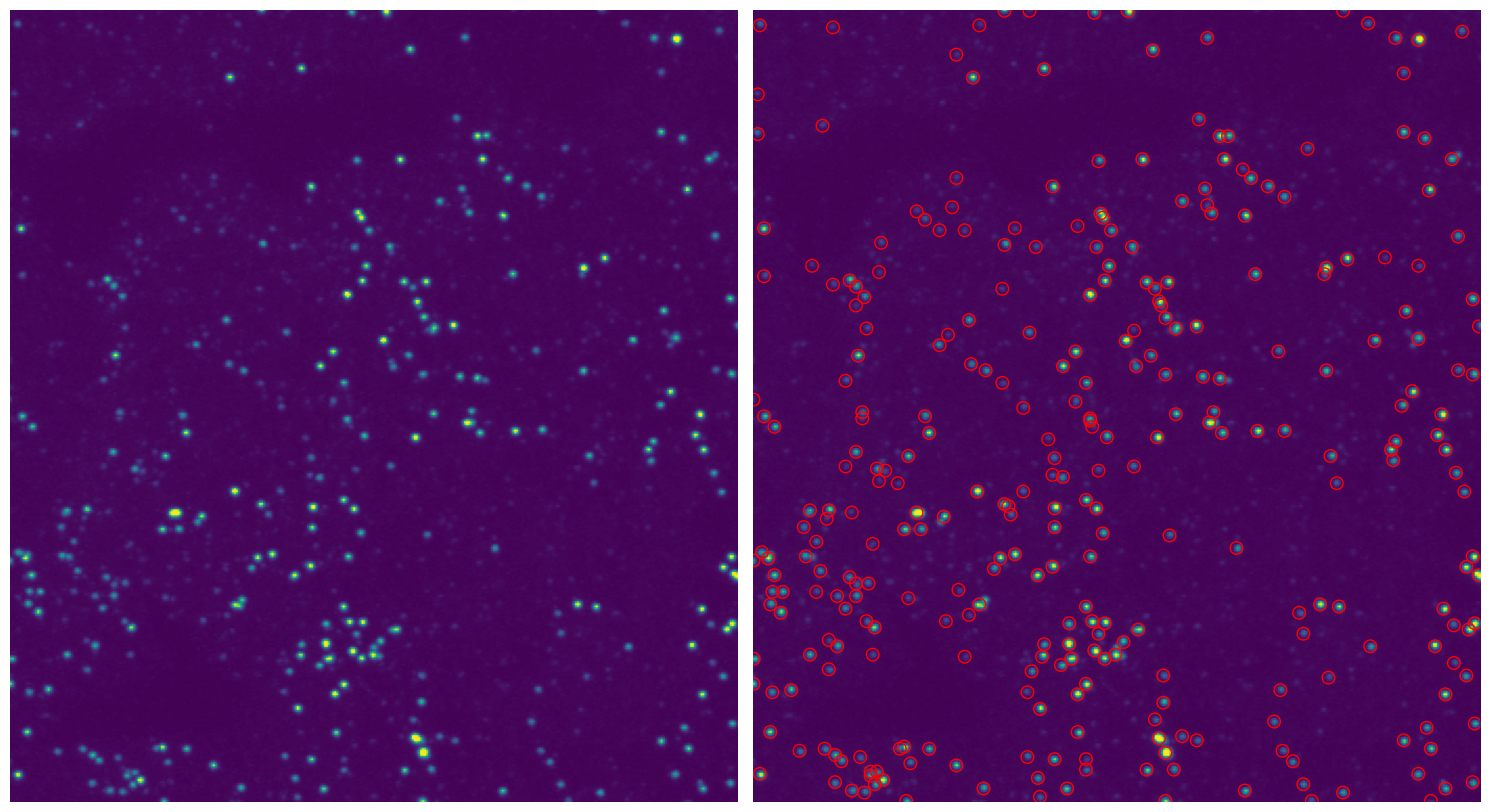

In [3]:
Pos = 1 # Specify the field of view number. In the test data, the field of view numbers range from 1 to 3.
cycle = 3 # In the test data, cycles 33 to 72 correspond to DNA-seqFISH data.
channel = 1 # In the test data, DNA-seqFISH data is acquired in 3 channels.
threshold = 43 # Set the threshold.

file_name = "ND" + f"{cycle:02d}" + "_C" + str(channel) + "_TyR.tif"
Pos_no = "Pos" + f"{Pos:02d}"
spot_detect_threshold(Pos_no, file_name, threshold)

Based on the threshold determined above, detect spots.
Within the folder 1_processed_images/6_RNA_seqFISH_spot_detection, folders for each field of view will be created, and information such as coordinates of detected RNA spots and RNA clusters detected within that field of view will be saved in CSV format. Additionally, in the img folder, PNG images highlighting detected RNA spots in red and detected clusters in blue will be saved.

In [ ]:
reference_data = pd.read_csv(os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-summary.csv"))
reference_data = reference_data.reset_index()
reference_data = reference_data.loc[(reference_data['exp_type']=='RNA_seqFISH') &
                                                   (~reference_data['Threshold'].isnull()),:]

path_output = os.path.join(dir, "1_processed_images", "6_RNA_seqFISH_spot_detection")
# If the specified path does not exist, create the directory.
if not os.path.exists(path_output):
    os.makedirs(path_output)

for pos in range(1,4):
    Pos_no = 'Pos' + str(pos).zfill(2)
    for stack_no in range(len(reference_data)):
        Stack_ID = str(reference_data.Stack_ID.values[stack_no])
        gene_name = reference_data.loc[reference_data['Stack_ID']==Stack_ID,'target_ID'].values[0]
        file_name = Stack_ID + '.tif'
        threshold = reference_data.loc[reference_data['Stack_ID']==Stack_ID,'Threshold'].values[0]

        path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

        path = os.path.join(path_input, Pos_no, file_name)
        # Select the smFISH image.
        dna  = stack.read_image(path)

        # Generate a MIP (Maximum Intensity Projection) image for image display.
        dna_mip = stack.maximum_projection(dna)


        # Spot detection
        # Perform filtering, detection of local maxima, detection of the optimal threshold, and detection of bright spots based on the threshold all at once.

        spots = detection.detect_spots(
            images=dna, 
            threshold = threshold,
            return_threshold=False, 
            voxel_size=(130, 130, 130),  # in nanometer (one value per dimension zyx)
            spot_radius=(240, 189, 189))  


        spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
            image=dna, 
            spots=spots, 
            voxel_size=(200, 130, 130), 
            spot_radius=(233, 189, 189), 
            alpha=0.7,  # alpha impacts the number of spots per candidate region
            beta=1,  # beta impacts the number of candidate regions to decompose
            gamma=5)  # gamma the filtering step to denoise the image

        spots_post_clustering, clusters = detection.detect_clusters(
            spots=spots_post_decomposition, 
            voxel_size=(200, 130, 130), 
            radius=350,
            nb_min_spots=3) 
        
        
        # Here, assign information regarding which nucleus each cluster belongs to.
        
        if len(clusters)>0:
            b = np.stack([0 for _ in range(clusters.shape[0])], axis=0)
            clusters = np.insert(clusters, 5, b, axis=1)
            
            for i in range(len(clusters)):
                path_input = os.path.join(dir,"1_processed_images","4_segmentation")
                nuc_file_name = "02_nuc_seg_human_corrected.tif"

                path = os.path.join(path_input, Pos_no, nuc_file_name)
                # Select the FISH image.
                nuc_seg  = stack.read_image(path)
                a = clusters[i][0:3]
                nuc_id = nuc_seg[a[0]][a[1]][a[2]]
                clusters[i][5] = nuc_id
                
        
        
        path_output = os.path.join(dir,"1_processed_images","6_RNA_seqFISH_spot_detection")
        path = os.path.join(path_output, Pos_no, 'img',Stack_ID + '_' + gene_name + '.png')
        
        if not os.path.exists(os.path.join(path_output, Pos_no, 'img')):
            os.makedirs(os.path.join(path_output, Pos_no, 'img'))

        plot.plot_detection(dna_mip, 
                            spots=[spots_post_decomposition, clusters[:, :3]], 
                            shape=["circle", "polygon"], 
                            radius=[3, 6], 
                            color=["red", "blue"],
                            linewidth=[1, 2], 
                            fill=[False, True], 
                            contrast=True,
                            title=Stack_ID + '_' + gene_name,
                            path_output=path, ext='png', show=False)


        # save in csv files
        path = os.path.join(path_output, Pos_no, Stack_ID + '_' + gene_name + "spots.csv")
        stack.save_data_to_csv(spots_post_clustering, path)
        path = os.path.join(path_output, Pos_no, Stack_ID + '_' + gene_name + "clusters.csv")
        stack.save_data_to_csv(clusters, path)